## Agenda

[Business Context](#Business-Context)<br> 
&emsp;[Business Questions](#Business-Context)<br>
&emsp;[Hypothesis](#Business-Context)<br>

[Imports](#Imports)<br>
&emsp;[Helper Functions and Classes](#Helper-Functions-and-Classes)<br>

[Settings](#Settings)<br>

[Loading Data](#Loading-Data)<br>
&emsp;[df_orders_abt](#df_orders_abt)<br>

[Analytical Base Table](#Analytical-Base-Table)<br>
&emsp;[df_sales](#df_sales)<br>


[Moving Average](#Moving-Average)<br>

[Train Test Split](#Train-Test-Split)<br>

[SARIMA](#SARIMA)<br>
&emsp;[Finding Best P, D, Q](#Finding-Best-P,-D,-Q)<br>

[Residual Analysis](#Residual-Analysis)<br>

[2023 Sales Forecast](#2023-Sales-Forecast)<br>

[Next Steps](#Next-Steps)<br>

## Business Context

E-Mart is a Chinese retailer that discovered the e-commerce as a way to sell to the entire world, rather than just to the population of their home city. The company has been growing without much worries, and now It wants to start using the data collected during its 4 years of e-commerce to keep growing and make more money.


The company has been growing without much worries, and now It wants to start using the data collected during the years to keep growing and make more money.
At first, the board of directors expects:

- A Dashboard with KPIs to track their growth.
<br>

- Robust Data Analysis, as well as recommendation of actions. What's the actionable based on your analysis?
<br>

- An Analysis on geolocation, a segmentation by sales, profit and more. They want insights to help increasing revenue.
<br>

- **Sales forecast for the next year, in order to enable strategic planning.**

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from datetime import datetime, timedelta 

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools
import warnings

### Helper Functions and Classes

In [28]:
def fig(x=15, y=5, set_as_global=False, reset_to_default=False):
    """ Adjust size of matplotlib figure

    x: figure width.
    y: figure height.
    set_as_global: bool.
        If True, then it sets "x" and "y" axis for all subsequent plots.
    reset_to_default: bool.
        If True, then it resets the global figure size back to default.
    """
    if set_as_global:
        plt.rcParams["figure.figsize"] = (x, y)
    elif reset_to_default:
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    else:
        plt.figure(figsize=(x,y))
        
        
def evaluate(y_true, y_pred, timeline_message=None, show_results=True):
    mae = mean_absolute_error(y_true, y_pred).round(2)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    if timeline_message:
        print(timeline_message)    
    if show_results:
        print(f'''On average, our predictions are {mape.round(2)}% above or below the real value.''')
        print(f'''Which means an error of about $ {"{:,.2f}".format(mae)}''')
    return mae, mape/100


def find_best_pdq(training_data, testing_data, time_series_name, 
                  p_range=range(0, 8), d_range=range(0, 2), q_range=range(0, 8),
                  seasonal_p_range=range(0, 1), seasonal_d_range=range(0, 1), seasonal_q_range=range(0, 1),
                  seasonality=range(2, 3),
                  max_combinations=128, sort_values_by='rmse'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        p, d, q = p_range, d_range, q_range
        sp, sd, sq = seasonal_p_range, seasonal_d_range, seasonal_q_range
        s = seasonality
        pdq_combination = list(itertools.product(p, d, q, sp, sd, sq, s)) # combinations
        rmse = []
        mae = []
        mape = []
        pdq_as_index = []

        for p, d, q, sp, sd, sq, s in pdq_combination[:max_combinations]:
            try:
                model = SARIMAX(training_data[time_series_name], order=(p, d, q), seasonal_order=(sp, sd, sq, s)).fit()
                predictions = model.forecast(len(testing_data))
                rmse_value = np.sqrt(mean_squared_error(testing_data[time_series_name], predictions))
                mae_value = mean_absolute_error(testing_data[time_series_name], predictions)
                mape_value = mean_absolute_percentage_error(testing_data[time_series_name], predictions)
                pdq_as_index.append((p, d, q, sp, sd, sq, s))
                rmse.append(rmse_value)
                mae.append(mae_value)
                mape.append(mape_value)
            except Exception as e:
                print(e)
                continue
#                 raise e

        return pd.DataFrame(data={'rmse': rmse, 'mae':mae, 'mape':mape},
                        index=pd.Series(pdq_as_index, name='pdq')).sort_values(sort_values_by)

### Settings

In [4]:
%matplotlib inline

In [5]:
pd.set_option('display.max_columns', 500)

fig(15, 5, set_as_global=True)

In [6]:
date_train_begin = pd.to_datetime('2019-01-01')
date_test_begin= pd.to_datetime('2022-01-01')
year_ago = (pd.to_datetime(date_test_begin) - timedelta(days=365)).date()
date_test_end = (date_test_begin + timedelta(days=365)).date()

## Loading Data

### df_orders_abt

In [7]:
df_orders_abt = pd.read_csv("../../data/growth_analysis/orders_abt.csv")

## Analytical Base Table


### df_sales

In [8]:
df_sales = df_orders_abt[['order_date', 'sales']]

df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])

df_sales.set_index('order_date', inplace=True)

C:\Users\Paulo H Sabino\AppData\Local\Temp\ipykernel_9500\1978695514.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])


## Moving Average

In [204]:
monthly_series = df_sales.resample("M").sum()
weekly_series = df_sales.resample("W").sum()

series = monthly_series

# Tests
# Monthly Series: (ma=3, mape=46.94%) | (ma=6, mape=48.08%)
# Weekly Series: (ma=26, mape=40.92%) | (ma=52, mape=34.52%)
moving_avg = 12
series = pd.concat([series, series.rolling(window=moving_avg).mean().shift(1)], axis=1).dropna()

series.columns = ['sales', 'moving_average']
series = series.resample('M').sum()
evaluate(series.loc[date_test_begin:, 'sales'], series.loc[date_test_begin:, 'moving_average']);

On average, our predictions are 44.04% above or below the real value.
Which means an error of about $ 1,405,704.42


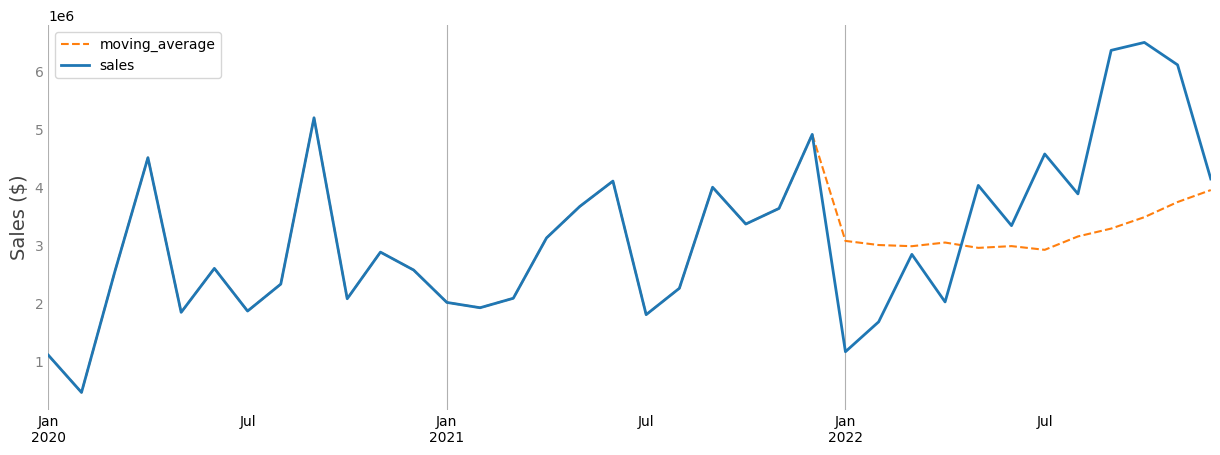

In [205]:
series['error'] = series['sales'] - series['moving_average']
series['absolute_error'] = series['error'].abs()
series['percentage_error'] = series['absolute_error'] / series['sales']

series.loc[:date_test_begin, 'moving_average'] = np.nan
series.loc[date_train_begin :date_test_begin, ['moving_average']] = series.loc[date_train_begin:date_test_begin, ['sales']].values

series['moving_average'].plot(style='--', color='#ff7f0e')
series['sales'].plot(linewidth=2)

plt.box(False)
plt.grid(axis='x')
plt.legend()
plt.tick_params(axis='both', which='both', length=0)
plt.ylabel("Sales ($)", size=14, color='#424242')
plt.xlabel(None)
plt.yticks(color='grey');

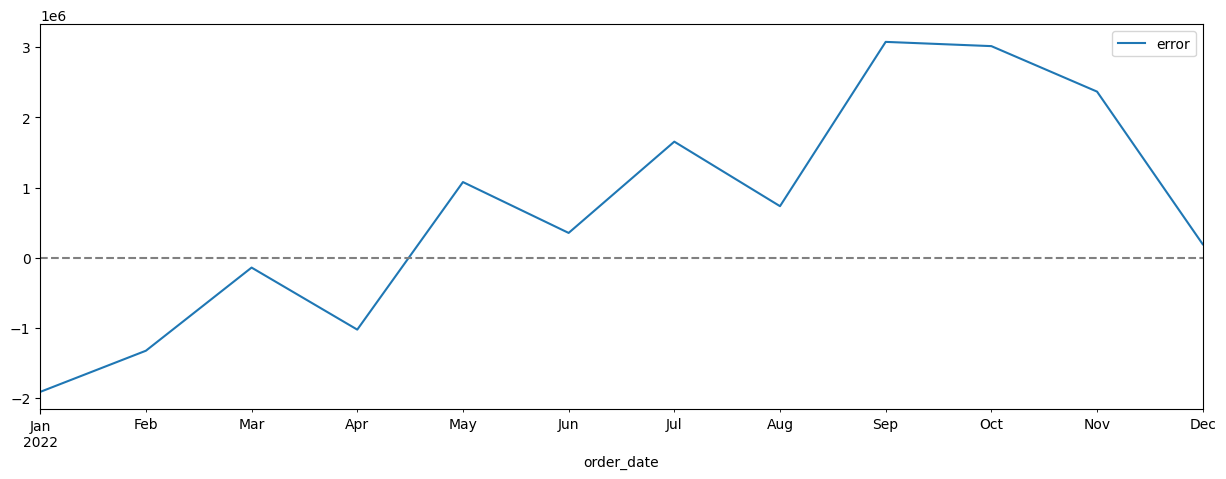

In [206]:
# There's room for improvement
series.loc[date_test_begin:, ['error']].plot()
plt.axhline(0, linestyle='--', color='grey');

## Train Test Split

In [167]:
evaluation = monthly_series.copy()
evaluation['sarima'] = np.nan
training_data = evaluation.loc[:date_test_begin]
testing_data = evaluation.loc[date_test_begin:]

## SARIMA

### Finding Best P, D, Q

In [168]:
p_range=[1, 12, 18]
d_range=[0, 1]
q_range=[1, 12, 18]
seasonal_p_range=[0, 1, 2]
seasonal_d_range=[0, 1, 2]
seasonal_q_range=[6, 12, 18]
seasonality=[12, 18]

p, d, q = p_range, d_range, q_range
sp, sd, sq = seasonal_p_range, seasonal_d_range, seasonal_q_range
s = seasonality
pdq_combination = list(itertools.product(p, d, q, sp, sd, sq, s)) # combin
len(pdq_combination)

972

In [169]:
%%time
# 972 combinations
# df_pdq = find_best_pdq(training_data=training_data, testing_data=testing_data, time_series_name='sales',
#                         max_combinations=400,
#                         p_range=[1, 12, 18],
#                         d_range=[0, 1],
#                         q_range=[1, 12, 18],
#                         seasonal_p_range=[0, 1, 2],
#                         seasonal_d_range=[0, 1, 2],
#                         seasonal_q_range=[6, 12, 18], seasonality=[12, 18])
# df_pdq.sort_values("mape").head()

CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\Paulo H Sabino\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Paulo H Sabino\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


On average, our predictions are 24.54% above or below the real value.
Which means an error of about $ 1,066,654.02


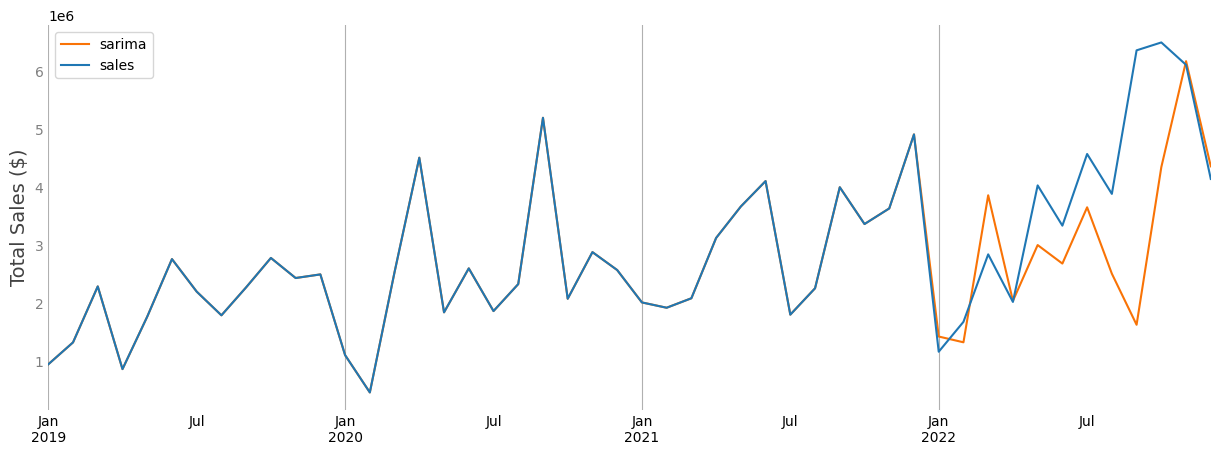

In [213]:
# Test
# ar=1; i=1; ma=1 0,1,0,12 --> 46.64%
# ar=12; i=1; ma=12 0,1,0,12 --> mape=35.64%
# ar=12; i=1; ma=12 0,1,0,18 --> mape=24.54%

ar=14; i=1; ma=12
model = SARIMAX(training_data['sales'].values, order=(ar,i,ma), seasonal_order=(0,1,0,18)).fit()
prediction = model.forecast(12)
evaluation.loc[date_test_begin:date_test_end, ['sarima']] = prediction
evaluation.loc[date_train_begin:date_test_begin, ['sarima']] = evaluation.loc[date_train_begin:date_test_begin, ['sales']].values
evaluation['error'] = evaluation['sales']-evaluation['sarima']

evaluation.loc[:date_test_end,  ['sarima', 'sales']].plot(color=['#F97306', '#1F77B4'])

plt.ylabel("Total Sales ($)", size=14, color='#424242')
plt.xlabel(None)
plt.box(False)
plt.grid(axis='x')
plt.legend()
plt.tick_params(axis='both', which='both', length=0)
plt.yticks(color='grey');


mae, mape = evaluate(evaluation.loc[date_test_begin:, 'sales'], evaluation.loc[date_test_begin:, 'sarima']);

## Residual Analysis




In [171]:
df_residuals = evaluation.loc[date_test_begin:]

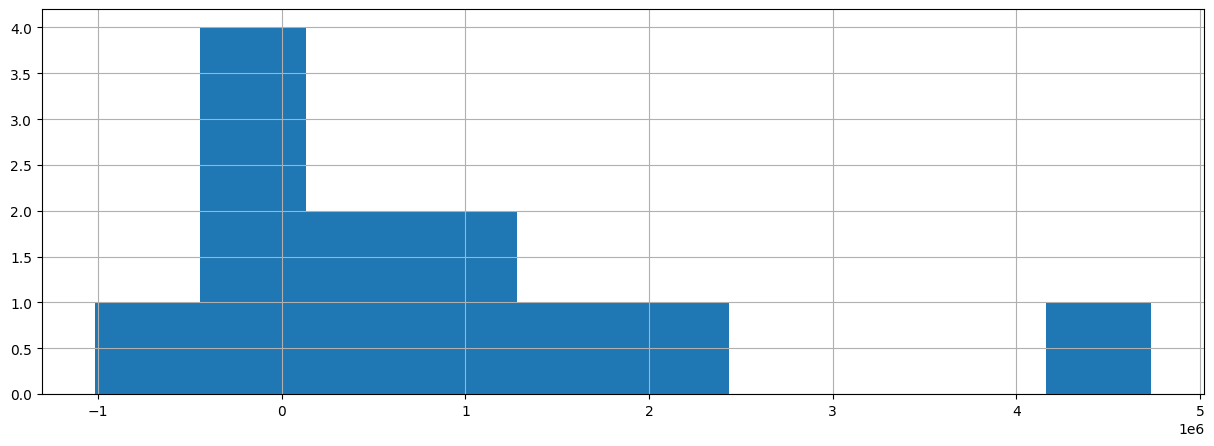

In [172]:
df_residuals['error'].hist();

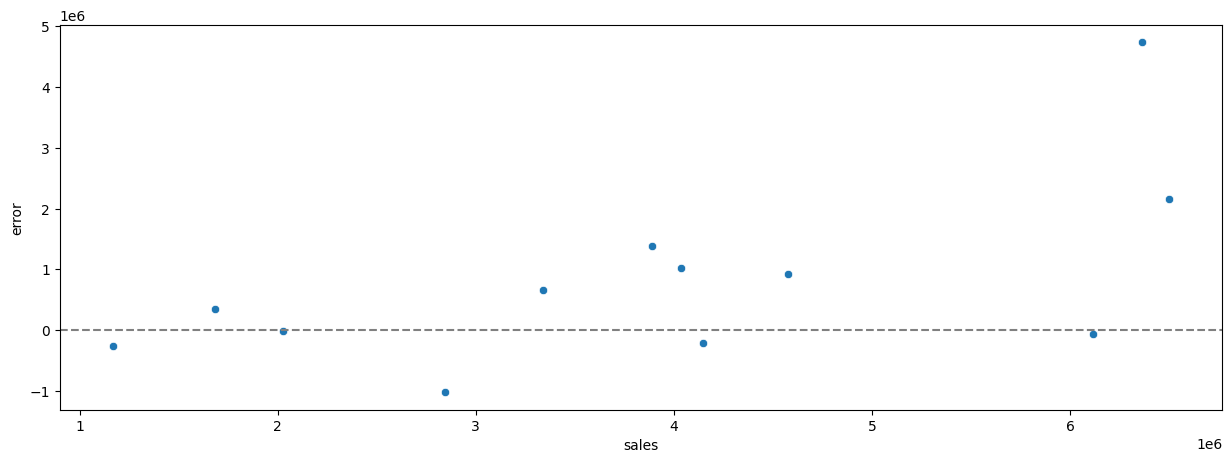

In [173]:
sns.scatterplot(data=df_residuals, x='sales', y='error')
plt.axhline(0, linestyle='--', color='grey');

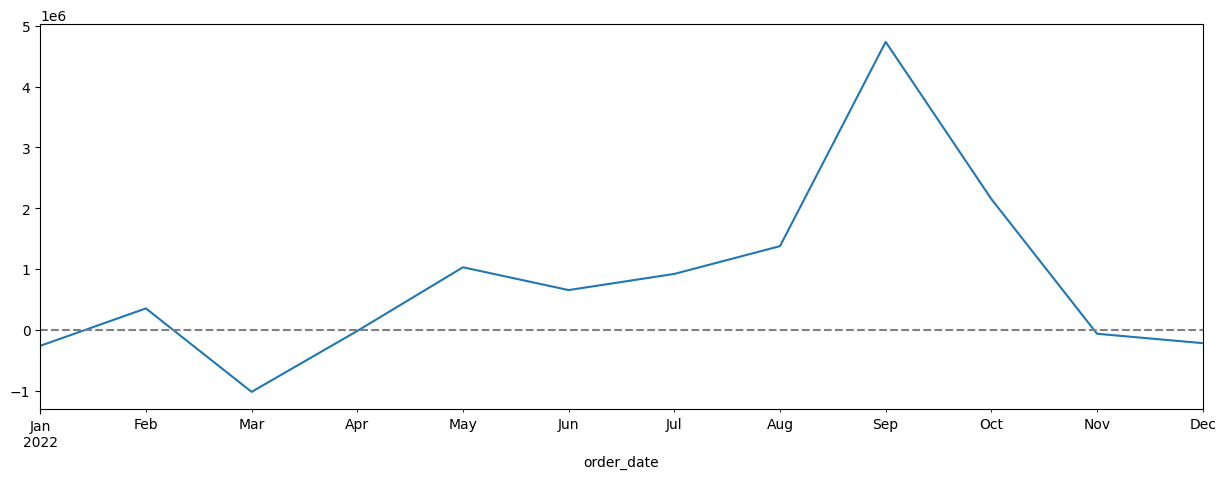

In [174]:
df_residuals['error'].plot()
plt.axhline(0, linestyle='--', color='grey');

## 2023 Sales Forecast

In [175]:
ar=14; i=1; ma=12
model = SARIMAX(evaluation['sales'].values, order=(ar,i,ma), seasonal_order=(0,1,0,18)).fit()
prediction = model.forecast(12)

C:\Users\Paulo H Sabino\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Paulo H Sabino\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [176]:
df_forecast = pd.concat([evaluation[['sales']],
                         pd.DataFrame({'forecast 2023':prediction}, index=pd.date_range(start='2023-01-01', periods=12, freq='M'))
                        ])
df_forecast.loc['2022-12-31', ['forecast 2023']] = df_forecast.loc['2022-12-31']['sales']

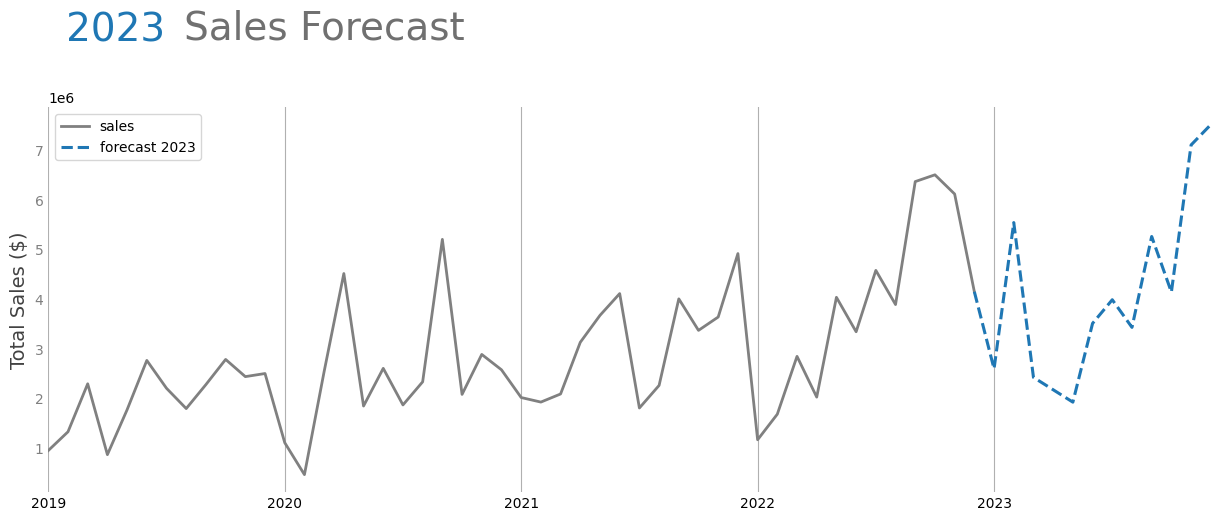

In [177]:
df_forecast['sales'].plot(linewidth=2, color='grey')
df_forecast['forecast 2023'].plot(linewidth=2.2, style='--')
plt.title(f"           Sales Forecast\n", fontsize=28, color='#707070', loc='left')
plt.text('2018-12-01', 8300000, "   2023\n", color='#1f77b4', size=28);

plt.ylabel("Total Sales ($)", size=14, color='#424242')
plt.xlabel(None)
plt.box(False)
plt.grid(axis='x')
plt.legend()
plt.tick_params(axis='both', which='both', length=0)
plt.yticks(color='grey');

In [178]:
df_forecast.loc['2023-01-01':, ['min_estimate']] = (df_forecast.loc['2023-01-01':, ['forecast 2023']] / (1 + mape)).values
df_forecast.loc['2023-01-01':, ['max_estimate']] = (df_forecast.loc['2023-01-01':, ['forecast 2023']] / (1 - mape)).values

In [179]:
df_forecast.loc['2022-12-31', ['min_estimate']] = df_forecast.loc['2022-12-31']['sales']
df_forecast.loc['2022-12-31', ['max_estimate']] = df_forecast.loc['2022-12-31']['sales']

In [180]:
df_aux = df_forecast.loc['2020-01-01':]

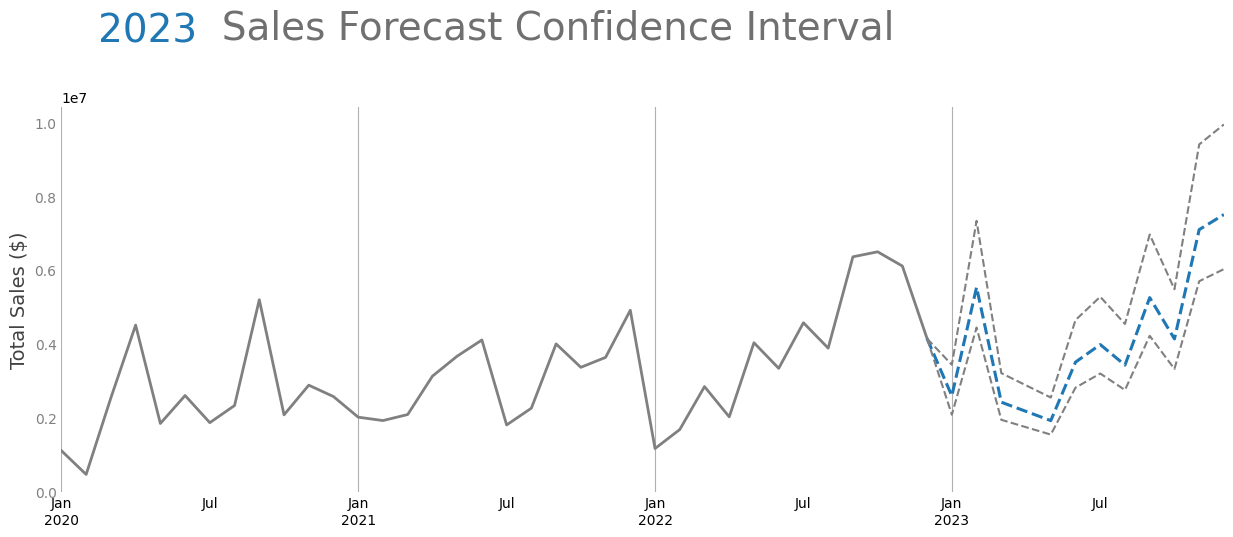

In [181]:
df_aux['sales'].plot(linewidth=2, color='grey')
df_aux['forecast 2023'].plot(linewidth=2.2, style='--') # , color='white'
df_aux['min_estimate'].plot(linewidth=1.5, style='--', color='grey')
df_aux['max_estimate'].plot(linewidth=1.5, style='--', color='grey')

plt.title(f"             Sales Forecast Confidence Interval\n", fontsize=28, color='#707070', loc='left')
plt.text('2020-01-01', 11001000, "   2023\n", color='#1f77b4', size=28);

plt.ylabel("Total Sales ($)", size=14, color='#424242')
plt.xlabel(None)
plt.box(False)
plt.grid(axis='x')
# plt.legend()
plt.tick_params(axis='both', which='both', length=0)
plt.yticks(color='grey');

## Next Steps

Try to Forecast Weekly then group by month.

Try using a Machine Learning Model to improve Forecast.

Forecast Monthly Quantity of Orders, then multiply by Average Ticket.

Residual Analysis: https://www.youtube.com/watch?v=XpQp7gP6BnQ